# CourtSumGER: German Court Summarization Dataset

## Raw Data
There are two different locations: 
- The full dataset here: https://huggingface.co/datasets/rusheeliyer/german-courts
- The excerpt from st and mp here:https://docs.google.com/spreadsheets/d/1EKI58wSObtLT0Uf_SH-R8FixGzQTpn1IuOVLDix03F8/edit?usp=sharing

The excerpt is somewhat deduplicated and cleaned up. The full dataset is not deduplicated and contains more information. It is here for informational purposes; we work with the full dataset in this notebook.

In [ ]:
import pandas as pd

splits = {'train': 'data/Bundesfinanzhof_train.csv',
          'test': 'data/Bundesfinanzhof_test.csv', 
          'validation': 'data/Bundesfinanzhof_val.csv'}
df = pd.read_csv("hf://datasets/rusheeliyer/german-courts/" + splits["train"])

In [2]:
print(df.head())
print(df.columns)

           id             date  \
0  bfh_001-11  05. Januar 2011   
1  bfh_001-12  04. Januar 2012   
2  bfh_001-13  02. Januar 2013   
3  bfh_001-14  08. Januar 2014   
4  bfh_001-15  07. Januar 2015   

                                             summary  \
0  Keine Steuerbefreiung für Umsätze eines gewerb...   
1  Schulgeld für nicht anerkannte Ergänzungsschul...   
2  Aufwandsentschädigungen ehrenamtlicher Betreue...   
3  Kosten eines Studiums, das eine Erstausbildung...   
4  Wirksame Übermittlung einer Einkommensteuererk...   

                                           judgement  
0  1. Die Umsätze eines gewerblichen Betreibers v...  
1  1. Schulgeld, das bis zum Veranlagungszeitraum...  
2  1. Betreuer üben eine sonstige vermögensverwal...  
3  1. Aufwendungen eines Steuerpflichtigen für ei...  
4  Eine Einkommensteuererklärung kann auch wirksa...  
Index(['id', 'date', 'summary', 'judgement'], dtype='object')


## Exploration

In [3]:
# Calculate the length of summary and judgement for filtering later
df['summary_length'] = df['summary'].str.len()
df['judgement_length'] = df['judgement'].str.len()

In [4]:
# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print(f"Number of duplicate IDs: {df['id'].duplicated().sum()}")

# Look at the distribution of years
df['year'] = df['date'].str.extract(r'(\d{4})').astype(int)
year_counts = df['year'].value_counts().sort_index()
print("\nDistribution of cases by year:")
print(year_counts)

Number of duplicate rows: 0
Number of duplicate IDs: 0

Distribution of cases by year:
year
2010    78
2011    74
2012    62
2013    73
2014    64
2015    64
2016    55
2017    55
2018    44
Name: count, dtype: int64


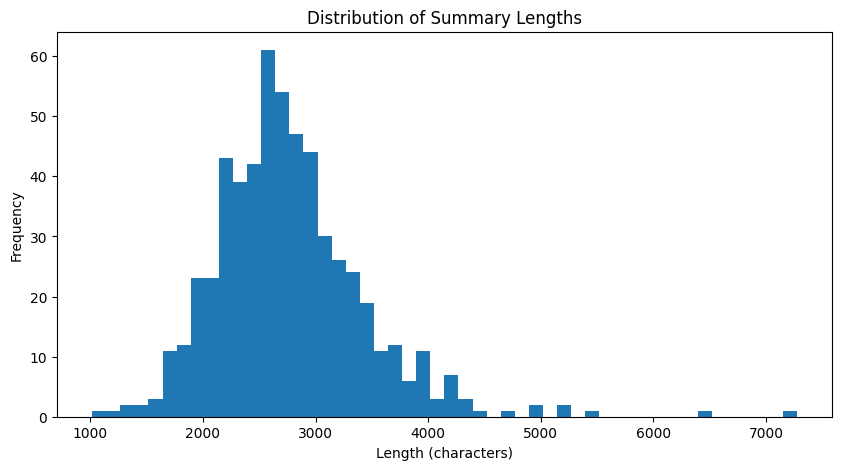


Very short summaries (potentially problematic):
             id                                            summary
17   bfh_004-12  Keine Aussetzungszinsen für fehlerhaft zu hoch...
73   bfh_014-14  Erstattungszinsen sind steuerbar\n            ...
99   bfh_018-12  Wesentliche Beteiligung: Maßgeblichkeit des Ge...
123  bfh_022-12  Richtigstellung\n                \n           ...
140  bfh_024-13  Prostituierte erzielen Einkünfte aus Gewerbebe...

Very long summaries (potentially problematic):
            id                                            summary
29  bfh_006-16  Häusliches Arbeitszimmer: Kein Abzug bei gemis...
33  bfh_007-13  Einkünfteerzielungsabsicht bei langjährigem Le...
53  bfh_010-17  BFH verwirft Sanierungserlass des BMF\n       ...
89  bfh_016-15  Arbeitszimmer eines Pensionärs im Keller\n    ...
97  bfh_017-18  Umsatzsteuerrechtliche Gleichbehandlung von Ph...


In [6]:
# Look for patterns in summaries that might indicate non-court case related entries
import matplotlib.pyplot as plt

# Display the distribution of summary lengths
plt.figure(figsize=(10, 5))
plt.hist(df['summary_length'], bins=50)
plt.title('Distribution of Summary Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Sample some very short and very long summaries
print("\nVery short summaries (potentially problematic):")
short_summaries = df[df['summary_length'] < df['summary_length'].quantile(0.05)]
print(short_summaries[['id', 'summary']].head())

print("\nVery long summaries (potentially problematic):")
long_summaries = df[df['summary_length'] > df['summary_length'].quantile(0.95)]
print(long_summaries[['id', 'summary']].head())

## Loading All Dataset Splits

Before we apply our cleaning process, let's load all the dataset splits (train, test, validation) to ensure our cleaning process is consistent across all of them.

In [7]:
# Load all splits
dfs = {}
for split_name, split_path in splits.items():
    dfs[split_name] = pd.read_csv("hf://datasets/rusheeliyer/german-courts/" + split_path)
    # Calculate lengths for each split
    dfs[split_name]['summary_length'] = dfs[split_name]['summary'].str.len()
    dfs[split_name]['judgement_length'] = dfs[split_name]['judgement'].str.len()
    print(f"Loaded {split_name} split with {len(dfs[split_name])} entries")

Loaded train split with 569 entries
Loaded test split with 133 entries
Loaded validation split with 59 entries


## Data Cleaning

We define a function that applies several criteria to determine if an entry is a valid court case with a corresponding press release.

In [ ]:
import re

def is_valid_court_case(row):
    """Function to determine if an entry is a valid court case press release.
    Focuses on content patterns rather than primarily on length."""
    summary = str(row['summary']) if not pd.isna(row['summary']) else ''
    judgment = str(row['judgement']) if not pd.isna(row['judgement']) else ''
    
    # Criteria for filtering:
    
    # 1. Both summary and judgment should exist (minimal length check)
    if pd.isna(row['summary']) or pd.isna(row['judgement']):
        return False
    
    # 2. Check for press release indicators in the summary
    # Look for court-case related terminology
    case_keywords = ['urteil', 'gericht', 'entscheidung', 'beschluss', 'klage', 
                     'revision', 'steuer', 'finanz', 'rechtsprechung', 'bundesfinanzhof', 
                     'rechtsbeschwerde', 'gesetzgeber', 'bfh', 'verfahren']
    
    if not any(keyword in summary.lower() for keyword in case_keywords):
        return False
    
    # 3. Exclude obvious non-case content
    exclusion_keywords = ['pressemitteilung', 'pressekonferenz', 'jahresbericht', 
                         'veröffentlichung', 'stellenausschreibung', 'einladung zum pressegespräch']
    
    # Check if these keywords appear prominently at the beginning of the summary
    summary_start = summary.lower()[:50]
    if any(keyword in summary_start for keyword in exclusion_keywords):
        return False
    
    # 4. Judgment structure check - Should resemble legal points
    # Look for patterns like numbered points, legal references, or formal structure
    legal_structure_patterns = [
        r'^\d+\.\s',  # Numbered points (e.g., "1. Die Umsätze...")
        r'^§\s*\d+',  # Legal paragraphs
        r'^Art\.\s*\d+', # Articles
        r'entscheidungsgründe', # Decision grounds
        r'tatbestand', # Facts of the case
        r'leitsatz', # Guiding principle
    ]
    
    judgment_start = judgment.strip().lower()[:200]
    has_legal_structure = any(re.search(pattern, judgment_start, re.IGNORECASE) for pattern in legal_structure_patterns)
    
    # For judgments not starting with typical patterns, check if they contain legal content
    legal_content_terms = ['gericht', 'gesetz', 'rechtsmittel', 'instanz', 'kläger', 'beklagt', 'senat', 
                         'urteil', 'entscheidung', 'vorinstanz', 'revision']
    
    if not has_legal_structure and not any(term in judgment_start for term in legal_content_terms):
        return False
    
    # 5. Semantic relationship - Check if summary and judgment seem related
    # Extract meaningful words (at least 4 chars) from both texts
    summary_words = set(re.findall(r'\b\w{4,}\b', summary.lower()))
    judgment_words = set(re.findall(r'\b\w{4,}\b', judgment.lower()))
    
    # Check for shared terminology
    common_words = summary_words.intersection(judgment_words)
    
    # More lenient threshold - even 2-3 common significant terms may indicate relationship
    # Exclude very common words that might appear in any document
    common_stopwords = {'nach', 'eine', 'eines', 'einer', 'einem', 'einen', 'nicht', 'oder', 'auch', 'dass', 'wenn', 'wird'}
    meaningful_common_words = common_words - common_stopwords
    
    if len(meaningful_common_words) < 2:
        return False
    
    return True

# Apply the improved filtering function to each dataset
cleaned_dfs = {}
for split_name, df_split in dfs.items():
    valid_mask = df_split.apply(is_valid_court_case, axis=1)
    cleaned_dfs[split_name] = df_split[valid_mask].copy()
    print(f"{split_name}: Removed {len(df_split) - len(cleaned_dfs[split_name])} out of {len(df_split)} entries")

# For simplicity, focus on the cleaned training set for further analysis
cleaned_df = cleaned_dfs['train']

train: Removed 249 out of 569 entries
test: Removed 45 out of 133 entries
validation: Removed 21 out of 59 entries


Let's examine some examples of entries that were removed and kept to verify our cleaning process:

In [9]:
# Examples of removed entries
removed_df = dfs['train'][~dfs['train'].index.isin(cleaned_dfs['train'].index)]
if len(removed_df) > 0:
    print("Examples of removed entries:")
    for idx, row in removed_df.head(3).iterrows():
        print(f"ID: {row['id']}")
        print(f"Summary: {row['summary'][:200]}...")
        print(f"Judgement: {row['judgement'][:200]}...")
        print("-" * 80)
else:
    print("No entries were removed from the train set.")

# Examples of kept entries
print("\nExamples of kept entries:")
for idx, row in cleaned_df.head(3).iterrows():
    print(f"ID: {row['id']}")
    print(f"Summary: {row['summary'][:200]}...")
    print(f"Judgement: {row['judgement'][:200]}...")
    print("-" * 80)

Examples of removed entries:
ID: bfh_001-15
Summary: Wirksame Übermittlung einer Einkommensteuererklärung per Fax
                
                  07. Januar 2015
                
                -
                  Nummer
                  001/15 - U...
Judgement: Eine Einkommensteuererklärung kann auch wirksam per Fax an das FA übermittelt werden. Es ist nicht erforderlich, dass der Steuerpflichtige den Inhalt der Einkommensteuererklärung tatsächlich in vollem...
--------------------------------------------------------------------------------
ID: bfh_002-14
Summary: Umfang der Rechtsbehelfsbelehrung
                
                  08. Januar 2014
                
                -
                  Nummer
                  002/14 - Urteil vom 20.11.2013
      ...
Judgement: Es reicht aus, wenn die Rechtsbehelfsbelehrung hinsichtlich der Formerfordernisse für die Einlegung eines Einspruchs den Wortlaut des § 357 Abs. 1 Satz 1 AO wiedergibt.
Tatbestand
I. Der Beklagte und ...
----

## Saving the Cleaned Dataset

In [10]:
# Import Path for directory creation
from pathlib import Path

# Create output directory if it doesn't exist
output_dir = Path('cleaned_data')
output_dir.mkdir(exist_ok=True)

# Save each cleaned split
for split_name, cleaned_split_df in cleaned_dfs.items():
    output_file = output_dir / f"cleaned_Bundesfinanzhof_{split_name}.csv"
    cleaned_split_df.to_csv(output_file, index=False)
    print(f"Saved {split_name} split to {output_file} with {len(cleaned_split_df)} entries")

# Optional: Save a combined version
combined_df = pd.concat(cleaned_dfs.values())
combined_output_file = output_dir / "cleaned_Bundesfinanzhof_combined.csv"
combined_df.to_csv(combined_output_file, index=False)
print(f"Saved combined dataset to {combined_output_file} with {len(combined_df)} entries")

Saved train split to cleaned_data/cleaned_Bundesfinanzhof_train.csv with 320 entries
Saved test split to cleaned_data/cleaned_Bundesfinanzhof_test.csv with 88 entries
Saved validation split to cleaned_data/cleaned_Bundesfinanzhof_validation.csv with 38 entries
Saved combined dataset to cleaned_data/cleaned_Bundesfinanzhof_combined.csv with 446 entries


## Steps - Summary

1. Data Loading
2. Data Exploration
3. Data Cleaning
Criteria:
   - Ensuring both summary and judgment fields are meaningful (not too short)
   - Filtering out entries with non-case-related keywords (like event announcements)
   - Ensuring the judgment has a proper legal structure
   - Checking that summary and judgment are semantically related

4. Saving the output